If you haven't already, please check out the [continuous tutorial](https://github.com/sibirica/PySPIDER/blob/main/tutorials/01_Continuous.ipynb) which goes over the simplest continuous case.

### Imports

You may need to run this cell (replacing the path with the location of the repository in your filesystem) in order to ensure that Python can find the imports.

In [1]:
import sys
sys.path.append('/Users/daniel/Princeton Dropbox/Daniel Gurevich/Research/discrete_sr/code/SPIDER_discrete/src')

We will again use numpy to generate the dataset and matplotlib for plotting.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation

We need essentially the same SPIDER imports as in the continuous case, except we now use the discrete version of SRDataset.

In [3]:
from PySPIDER.commons.library import Observable
from PySPIDER.discrete.process_library_terms import SRDataset

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Generating the dataset
As a toy example, we generate 1600 particles on a square domain with periodic boundaries, which do not interact with each other and move at constant velocities.

In [4]:
L = 80 # size of domain
rho = 1 # density of particles
N = int(rho*L**2) # number of particles
 
deltat = 1.0 # time step
vmax = 4/15 # max particle speed
iterations = 250 # number of time steps

# note that the array axes are (particle #, component of observable, t) - this is the correct input format for SPIDER
positions = np.zeros(shape=(N,2,iterations))
v = np.zeros(shape=(N,2,iterations))
r = np.random.uniform(L/12, 11*L/12, size=(N,2))
v0 = np.random.uniform(-vmax/np.sqrt(2), vmax/np.sqrt(2), size=(N,2))

# evolve the particles forward with periodic boundaries
for i in range(iterations):
    r += deltat*v0
    r[r>L] -= L
    r[r<0] += L
    
    positions[:, :, i] = r
    v[:, :, i] = v0

Pay careful attention to the format of the data: they are numpy arrays with axes (particle index, \[optional components\], t), For instance, the particle velocity $v$ corresponds to a 3D numpy array (#, 0=x or 1=y, t), whereas a scalar $s$ should be represented by a 2D array with axes (#, t). Currently, discrete SPIDER best supports datasets in two spatial dimensions, though it can run 3D with some modifications from this tutorial.

If you want, you can generate a movie showing the particles and their velocities over time (requires an FFMpeg installation):

t=0
t=0
t=0
t=0
t=10
t=20
t=30
t=40
t=50
t=60
t=70
t=80
t=90
t=100
t=110
t=120
t=130
t=140
t=150
t=160
t=170
t=180
t=190
t=200
t=210
t=220
t=230
t=240


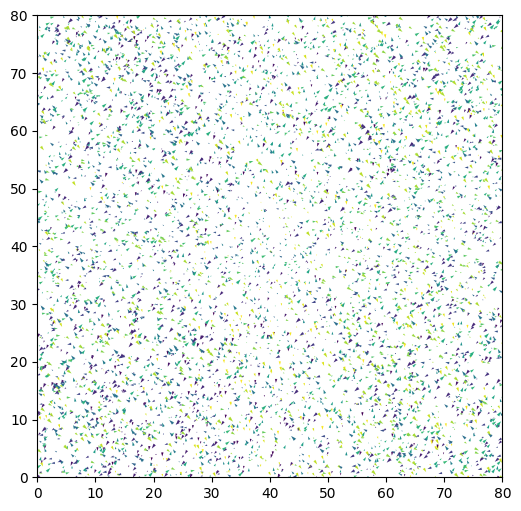

In [5]:
fig, ax = plt.subplots(figsize=(6,6)) 
qv = ax.quiver(r[:,0], r[:,1], v0[:,0], v0[:, 1], np.arctan2(v0[:,0], v0[:,1]), clim=[-np.pi, np.pi])
ax.axis([0, L, 0, L])
 
def animate(i):
    if i%10==0:
        print(f"t={i}")
    qv.set_offsets(positions[:, :, i])
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg' # replace this with your FFMPEG path
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save('burgers.mp4', writer=FFwriter, dpi=100)

### Defining and evaluating SPIDER objects

Similarly to the continuous case, let's define an Observable object representing the particle velocity ${\bf v}$ and create a mapping from the observable names to the numpy data arrays.

In [6]:
v_obs = Observable(string='v', rank=1)
observables = [v_obs]
data_dict = {}
data_dict['v'] = v

Let's finish setting up the dataset. Unlike the continuous case, spatial measurements in discrete SPIDER use physical units, since there is no underlying grid. For the time axis, we still use grid points, with the conversion factor deltat.

We also need to define two additional hyperparameters: the length scale of the coarse-graining kernel, kernel_sigma, and the number of grid points per physical unit, cg_res. Since the width of the domain is $L=80$ and the mean spacing between particles is 1, reasonable choice are 3 and 2 respectively (evaluating the coarse-grained quantities on a 240x240 grid and averaging over ~(2x2)^2=16 particles at each point). By default, a compactly-supported polynomial kernel is used, though Gaussian kernels are also implemented.

In [7]:
world_size = np.array([L, L, iterations]) # dimensions of the dataset in physical units
np.random.seed(1) # set the random seed so the random sample of integration domains is fixed

# initial setup of the dataset object
kernel_sigma = 3
cg_res = 2
# note the additional parameters particle_pos, kernel_sigma, cg_res, and deltat 
# which are not used in the continuous case
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables,
                irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat)
# another useful parameter is rho_scale, which sets the scaling factor for the 
# coarse-grained density - e.g., rho_scale=100 divides rho by 100

With the caveat of using physical units for the width of the integration domain, the rest of the setup works the same way as in the continuous case.

In [8]:
srd.make_libraries(max_complexity=5, max_rho=2) # include at most two primes in each term
for irrep in srd.irreps:
    print(f"The {irrep} library has {len(srd.libs[irrep].terms)} terms:")
    print(srd.libs[irrep].terms)
    print()

The Rank 0 library has 42 terms:
[ρ, ρ · ρ, ρ · ∂α² ρ, ρ · ∂t ρ, ρ · ∂t ∂α² ρ, ρ · ∂t² ρ, ρ · ∂t³ ρ, ρ · ∂α ρ[v_α], ρ · ∂t ∂α ρ[v_α], ρ · ρ[v_α · v_α], ρ · ∂t ρ[v_α · v_α], ∂α ρ · ∂α ρ, ∂α ρ · ∂t ∂α ρ, ∂α ρ · ρ[v_α], ∂α ρ · ∂t ρ[v_α], ∂α² ρ, ∂α² ρ · ∂t ρ, ∂α² ∂β² ρ, ∂t ρ, ∂t ρ · ∂t ρ, ∂t ρ · ∂t² ρ, ∂t ρ · ∂α ρ[v_α], ∂t ρ · ρ[v_α · v_α], ∂t ∂α ρ · ρ[v_α], ∂t ∂α² ρ, ∂t² ρ, ∂t² ∂α² ρ, ∂t³ ρ, ∂t⁴ ρ, ρ[v_α] · ρ[v_α], ρ[v_α] · ∂t ρ[v_α], ∂α ρ[v_α], ∂α² ∂β ρ[v_β], ∂t ∂α ρ[v_α], ∂t² ∂α ρ[v_α], ρ[v_α · v_α], ∂α ∂β ρ[v_α · v_β], ∂α² ρ[v_β · v_β], ∂t ρ[v_α · v_α], ∂t² ρ[v_α · v_α], ∂α ρ[v_α · v_β · v_β], ρ[v_α · v_α · v_β · v_β]]

The Rank 1 library has 50 terms:
[ρ · ∂α ρ, ρ · ∂α ∂β² ρ, ρ · ∂t ∂α ρ, ρ · ∂t² ∂α ρ, ρ · ρ[v_α], ρ · ∂α ∂β ρ[v_β], ρ · ∂β² ρ[v_α], ρ · ∂t ρ[v_α], ρ · ∂t² ρ[v_α], ρ · ∂α ρ[v_β · v_β], ρ · ∂β ρ[v_α · v_β], ρ · ρ[v_α · v_β · v_β], ∂α ρ, ∂α ρ · ∂β² ρ, ∂β ρ · ∂α ∂β ρ, ∂α ρ · ∂t ρ, ∂α ρ · ∂t² ρ, ∂β ρ · ∂α ρ[v_β], ∂β ρ · ∂β ρ[v_α], ∂α ρ · ∂β ρ[v_β], ∂α ρ · ρ[v_β · v_β], ∂β ρ ·

Tip: using multiple weight functions per domain allows us to spend less time on coarse-graining, which is computationally expensive.

To ensure accuracy of the results, it is important to set a large enough 'pad' parameter so that the coarse-graining doesn't rely on unavailable data outside the domain. For the default coarse-graining function, 4 kernel_sigma is sufficient.

In [9]:
dom_width = 10
dom_time = 30

srd.make_domains(ndomains=20, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4)
srd.make_weights(m=8, qmax=1)
srd.set_LT_scale(L=1, T=1) # note that this line must go before make_library_matrices

In [10]:
srd.make_library_matrices(debug=False) # this may take a few minutes

### Regression

Regression works exactly the same way as for the continuous version of the problem.

In [11]:
from PySPIDER.commons.identify_models import *

reg_opts_list = []
for irrep in srd.irreps:
    # for regression we need to construct Scaler, Initializer, ModelIterator, and Threshold objects
    scaler = Scaler(sub_inds=None, char_sizes=srd.libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=1)

    # compute initial k=10 guess via truncated inverse iteration
    init = Initializer(method='power', start_k=10) 
    # complete up to 3 backward-forward passes over 1<=k<=10
    iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3) 
    res = Residual(residual_type='matrix_relative') # Frobenius residual

    # jump criterion: gamma=1.5, and continue to remove terms until r>delta
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8)
    
    # put everything together into an options dictionary
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False # setting to True outputs all of the debug info
    reg_opts_list.append(opts)

# now we can run the regression
eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([srd.libs[i] for i in srd.irreps], 
reg_opts_list, threshold=1e-6, report_accuracy=True)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.01 s]
Identified model: 1 · ∂t ρ + ∂α ρ[v_α] = 0 (order 3, residual 3.06e-07)
(r_h = 6.63e-07)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 4 ---
--- 

The toy example of non-interacting particles is very nice, since all of moments of the density ${\bf m}$ simply advect:
$$ D{\bf m}=\partial_t {\bf m} + ({\bf v} \cdot \nabla){\bf m} = 0$$ This matches the results found by SPIDER, which include mass conservation $$\partial_t \rho + \partial_\alpha \rho[v_\alpha] = 0$$ and the multidimensional inviscid Burgers' equation $$\partial_t \rho[v_\alpha] + \partial_\beta \rho[v_\alpha v_\beta] = 0.$$